---
## **Definition of convolution**
---
Consider some input time signal $f(t)$, output time signal $g(t)$ and system function $w(t)$ such that

\begin{align*}
w[f(t)] = g(t) \, .
\end{align*}

A system maps an input signal $f(t)$ onto an output signal $g(t)$. Thus we define the convolution of $w(t)$ and $f(t)$ as:

\begin{align*}
g(t) &= \int_{-\infty}^{\infty} w(\tau)f(t-\tau)\, d\tau \, .
\end{align*}

Or in standard notation

\begin{align*}
g(t) = f(t) * w(t) \, .
\end{align*}

In the real world all our time series are sampled at some time interval $\Delta$, such that the discrete time series are given by:

\begin{align*}
f_k = f(t_k) = f(k\Delta), && w_k = w(t_k) = w(k\Delta) \, .
\end{align*}

Such that the discrete convolution is expressed as follows:

\begin{align*}
g_n = \left[\sum_{k=-\infty}^\infty f_{n-k}w_k\right]\Delta \, .
\end{align*}

In practice both the input signal and system function are finite and the algorithm ends up becoming an iterative addition of the two arrays. Where the input signal gets reversed. 

Here is an example of a convolution function written by me. The idea behind this function is to run an iterative dot product on a padded array of $f$ such that the ends of the array match the dimensions of the system array.

In [3]:
import numpy as np
def myConv(f,w,dt):
    '''
    #######################################
    # Description                         #
    # Computes the convolution of f and w # 
    # through iterative dot product.      #
    #######################################
    # Inputs                              #
    # f: input time signal                #
    # w: system funciton                  #
    # dt: sampling interval               #
    #######################################
    # Outputs                             #
    # convolution np array of size        #
    # len(f) + len(w) - 1                 #
    ####################################### 
    '''
    # Pad the input array for ends to match len(w)
    f = np.pad(f,len(w)-1)
    # Reverse its order
    f = f[::-1]
    # Initialize empty array for convolution
    g = []
    # Iterate through length of system array
    for i in range(len(f)):
        # Select a chunk of padded f array
        fi = f[i:len(w)+i]
        # Check vectors are of same length
        if len(fi) != len(w):
            # Will only break once reach padded section
            break
        # Compute dot product
        gi = np.dot(fi,w)
        # Append dot product
        g.append(gi)
    # Reverse back the order of convolution array
    # and multiply by sampling interval
    return(np.array(g[::-1])*dt)

<h2 align='center'> Code Examples of Convolutions</h2>
<p1> Here we will use two system functions, a heavyside step function and a delta function defined as follows:</p1>

\begin{align*}
H(t) = \begin{cases}
        1 & t \geq 0\\
        0 & t < 0
    \end{cases}\\
\text{and}\\
\delta(t) \begin{cases}
    1 & t = 0\\
    0 & \text{else}
    \end{cases} \, .
\end{align*}

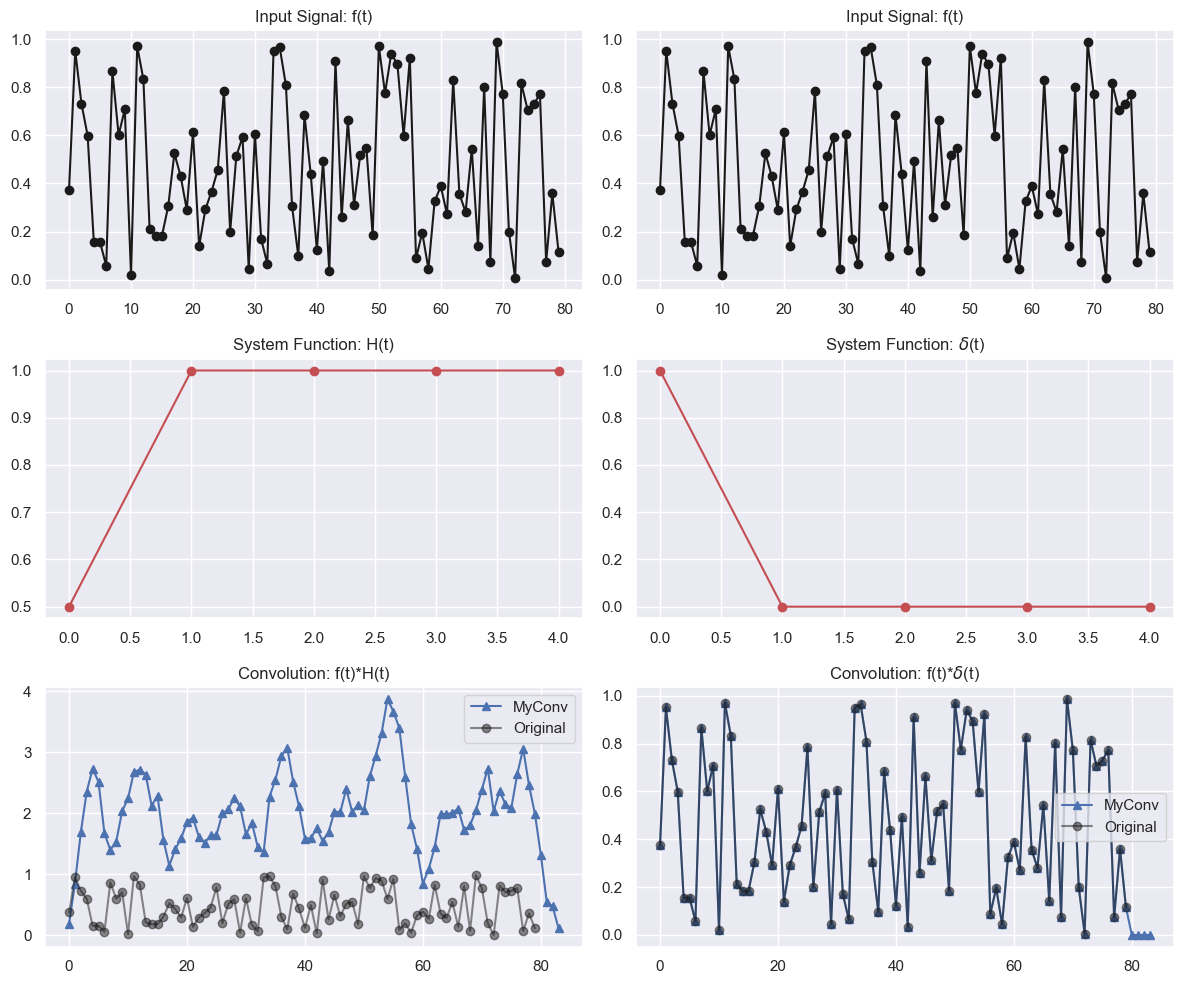

In [4]:
# Import needed libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define signal and system function discrete arrays.
np.random.seed(42)
f = np.random.uniform(0,1,size=80)

# Discretize the step function
def discrete_H(N):
    '''Returns a discrete array for H with N elements'''
    h1 = [0.5]
    h2 = np.ones(N-1)
    H = np.concatenate((h1,h2))
    return(H)
# Discretize the delta function
def discrete_delta(N,dt):
    '''Returns a discrete array for delta with N elements and 1/dt as first element'''
    d1 = [1/dt]
    d2 = np.zeros(N-1)
    D = np.concatenate((d1,d2))
    return(D)

# Create step funtion of 5 elements and delta function
w = discrete_H(5)
w2 = discrete_delta(5,1)

# Compute convolution
g = np.convolve(f,w)
g2 = np.convolve(f,w2)
g3 = myConv(f,w,1) # type: ignore
g4 = myConv(f,w2,1) # type: ignore

fig, ax = plt.subplots(figsize=(12,10),nrows=3,ncols=2,gridspec_kw={'height_ratios': [1, 1, 1]})
ax[0][0].plot(np.arange(0,len(f),1),f,marker='o',c='k')
ax[0][0].set_title('Input Signal: f(t)')
ax[1][0].plot(np.arange(0,len(w),1),w,marker='o',c='r')
ax[1][0].set_title('System Function: H(t)')
#ax[2][0].plot(np.arange(0,len(g),1),g,marker='o',c='orange',alpha=0.7,label='Numpy')
ax[2][0].plot(np.arange(0,len(g3),1),g3,marker='^',label='MyConv')
ax[2][0].plot(np.arange(0,len(f),1),f,marker='o',c='k',alpha=0.5,label='Original')
ax[2][0].set_title('Convolution: f(t)*H(t)')
ax[2][0].legend()

ax[0][1].plot(np.arange(0,len(f),1),f,marker='o',c='k')
ax[0][1].set_title('Input Signal: f(t)')
ax[1][1].plot(np.arange(0,len(w2),1),w2,marker='o',c='r')
ax[1][1].set_title(r'System Function: $\delta$(t)')
#ax[2][1].plot(np.arange(0,len(g2),1),g2,marker='o',c='orange',alpha=0.7,label='Numpy')
ax[2][1].plot(np.arange(0,len(g4),1),g4,marker='^',label='MyConv')
ax[2][1].plot(np.arange(0,len(f),1),f,marker='o',c='k',label='Original',alpha=0.5)
ax[2][1].set_title(r'Convolution: f(t)*$\delta$(t)')
ax[2][1].legend()
plt.tight_layout()
plt.savefig("Figures/Basic_1D_Convolutions.png")

---
Basic Filtering through Direct Convolutions

---
With this basic understanding of convolutions we can start applying different systems functions to signals and we can qualitatively review their effects on the data.
We can define a system function that looks like a boxcar with amplitude $1/N$ where $N$ is the lenght of the boxcar. This will replicate the results of a moving average as this is effectively summing up $x_i/N$ elements.

In [13]:
# Import pre-defined system functions
from System_Functions import *
import pandas as pd

# Load data
df = pd.read_csv('Data/DailyDelhiClimateTrain.csv')
# Cast date column as datetime object
df.date = pd.to_datetime(df.date)
# Set time array
t = (df['date'] - df['date'][0]).dt.days
# Define boxcar 
MA_Boxcar = MovingAverage(int(1e2))
# Use meantemp col as signal
y = np.array(df.meantemp)
g = np.convolve(y,MA_Boxcar,mode='same')

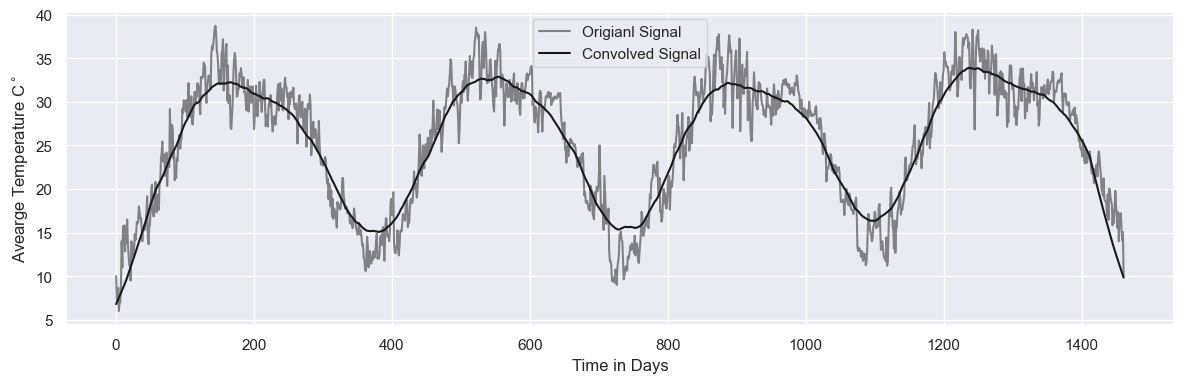

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,y,label='Origianl Signal',c='k',alpha=0.5)
ax.plot(t,g,label='Convolved Signal',c='k')
ax.set_xlabel('Time in Days')
ax.set_ylabel(r'Avearge Temperature C$^\circ$')
ax.legend()
plt.tight_layout()
plt.savefig('Figures/Data_MA.png')


---
Advanced Filtering through Fast Fourier transforms and convolutions

---
<!-- The convolution theorem states that for two functions $f(t)$ and $g(t)$ expressed in time-domain; their convolution is equal to their multiplication in frequency domain. Where $F(\omega)$ and $G(\omega)$ are the representations of said function in the frequency domain, after being fourier transformed. More formmaly
$$
f(t) * g(t) = F(\omega)G(\omega)
$$
Following I will provide a direct proof of the convolution theorem by noting that the inverse fourier transform (IFT) of a function is given by
$$
f(t) = \frac{1}{2\pi}\int F(\omega)e^{i\omega t} d\omega
$$ -->
The **convolution theorem** states that the convolution of two functions, $f(t)$ and $g(t)$, in the time domain is equivalent to their pointwise multiplication in the frequency domain. Let $F(\omega)$ and $G(\omega)$ represent the Fourier transforms of $f(t)$ and $g(t)$, respectively. More formally, this can be expressed as:  
$$
f(t) * g(t) = F(\omega) G(\omega)
$$

In the following, I will provide a direct proof of the convolution theorem. To begin, recall that the inverse Fourier transform (IFT) of a function is given by:  
$$
f(t) = \frac{1}{2\pi} \int F(\omega)e^{i\omega t} \, d\omega
$$
---
**Proof**:
Given the following convolved function $g(t) = w(t) * f(t)$ which is explicitly written as follows;
$$
g(t) = \int_{-\infty}^{\infty}w(t)f(t-\tau) d\tau
$$
We can re-write $f$ and $w$ in their frequency-domain representation through IFT
$$
g(t) = \frac{1}{4\pi^2}\iiint W(\omega')F(\omega)e^{i\omega'\tau}e^{i\omega(t-\tau)} d\omega'd\omega d\tau\\
g(t) = \frac{1}{2\pi}\iint W(\omega')F(\omega)\frac{1}{2\pi}\left[\int e^{i\tau(\omega' - \omega)} d\tau \right] e^{i\omega t}\, d\omega d\omega'\\
g(t) = \frac{1}{2\pi}\iint W(\omega')F(\omega)\delta(\omega' - \omega) e^{i\omega t}\, d\omega d\omega'\\
g(t) = \frac{1}{2\pi}\int W(\omega)F(\omega) e^{i\omega t}\, d\omega
$$
By inspection
$$
G(\omega) = F(\omega)W(\omega)
$$
Or more explictly;
$$
g(t) = \frac{1}{2\pi}\int G(\omega)e^{i\omega t}\, d\omega
$$

---

The primary advantage of the convolution theorem is that it allows us to connect the frequency representation of the product of two functions back to the temporal domain. This is particularly useful because most filters used in practice—such as band-pass, low-pass, and high-pass filters—operate in the frequency domain. When we multiply these filters by an input signal in the frequency domain, we effectively "eliminate" all frequencies outside the filter's range.

To illustrate this, we will begin by examining two types of filters: an idealized filter, like a boxcar filter, and a practical filter, like a sinc function.

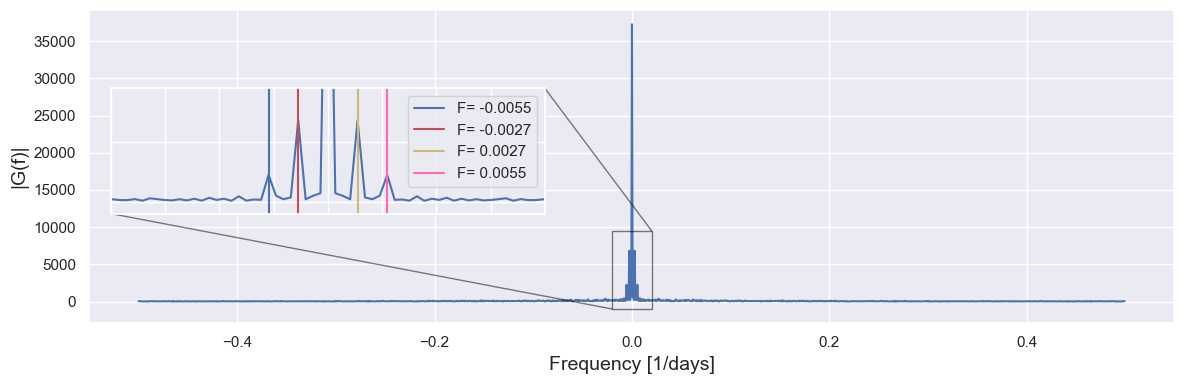

In [12]:
from scipy.signal import find_peaks

# Compute frequency given time arrat and sampling intervale
dt = 1
freq = np.fft.fftshift(np.fft.fftfreq(len(t),dt))
# Take FFT of signal
Y = np.fft.fftshift(np.fft.fft(y))
Y_abs = np.abs(Y)

# Find harmonic frequencies
pk_loc, pk_h = find_peaks(Y_abs,height=(2000,10000))

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freq,np.abs(Y_abs))
# Inset Axes....
x1, x2, y1, y2 = -0.02, 0.02, -1000, 9500  # subregion of the original image
axins = ax.inset_axes(
    [0.02, 0.35, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), yticklabels=[],xticklabels=[])
axins.plot(freq,Y_abs)
axins.axvline(x=freq[pk_loc[0]],label=f'F= {round(freq[pk_loc[0]],4)}')
axins.axvline(x=freq[pk_loc[1]],label=f'F= {round(freq[pk_loc[1]],4)}',c='r')
axins.axvline(x=freq[pk_loc[2]],label=f'F= {round(freq[pk_loc[2]],4)}',c='y')
axins.axvline(x=freq[pk_loc[3]],label=f'F= {round(freq[pk_loc[3]],4)}',c='hotpink')
axins.legend()
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_xlabel('Frequency [1/days]',fontsize=14)
ax.set_ylabel('|G(f)|',fontsize=14)
plt.tight_layout()

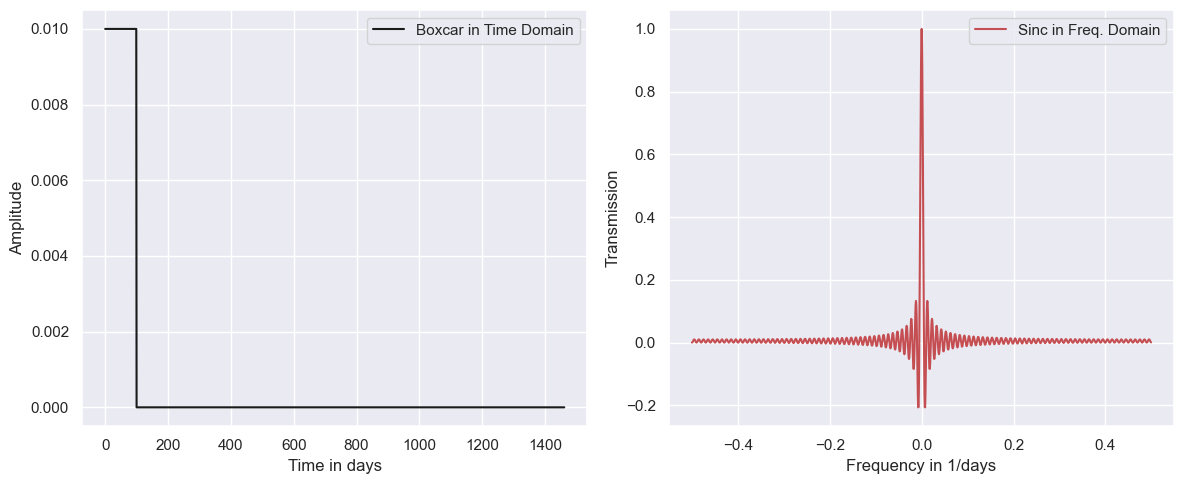

In [38]:
# The fft of the boxcar is a sinc function
# Convolving a boxcar is the same as multiplication of sinc in frequency domain
# Define sinc filter with respect to MA boxcar
MA_Boxcar_Filter = np.concatenate((MA_Boxcar,np.zeros(len(t)-len(MA_Boxcar))))
Sinc = np.fft.fftshift(np.fft.fft(MA_Boxcar_Filter))

fig, (a0, a1) = plt.subplots(figsize=(12,5),ncols=2)
a0.set_xlabel("Time in days")
a0.set_ylabel("Amplitude")
a0.plot(t,MA_Boxcar_Filter,c='k',label='Boxcar in Time Domain')
a0.legend()
a1.set_xlabel("Frequency in 1/days")
a1.set_ylabel("Transmission")
a1.plot(freq,Sinc.real,c='r',label='Sinc in Freq. Domain')
a1.legend()
plt.tight_layout()


c:\Users\patri\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


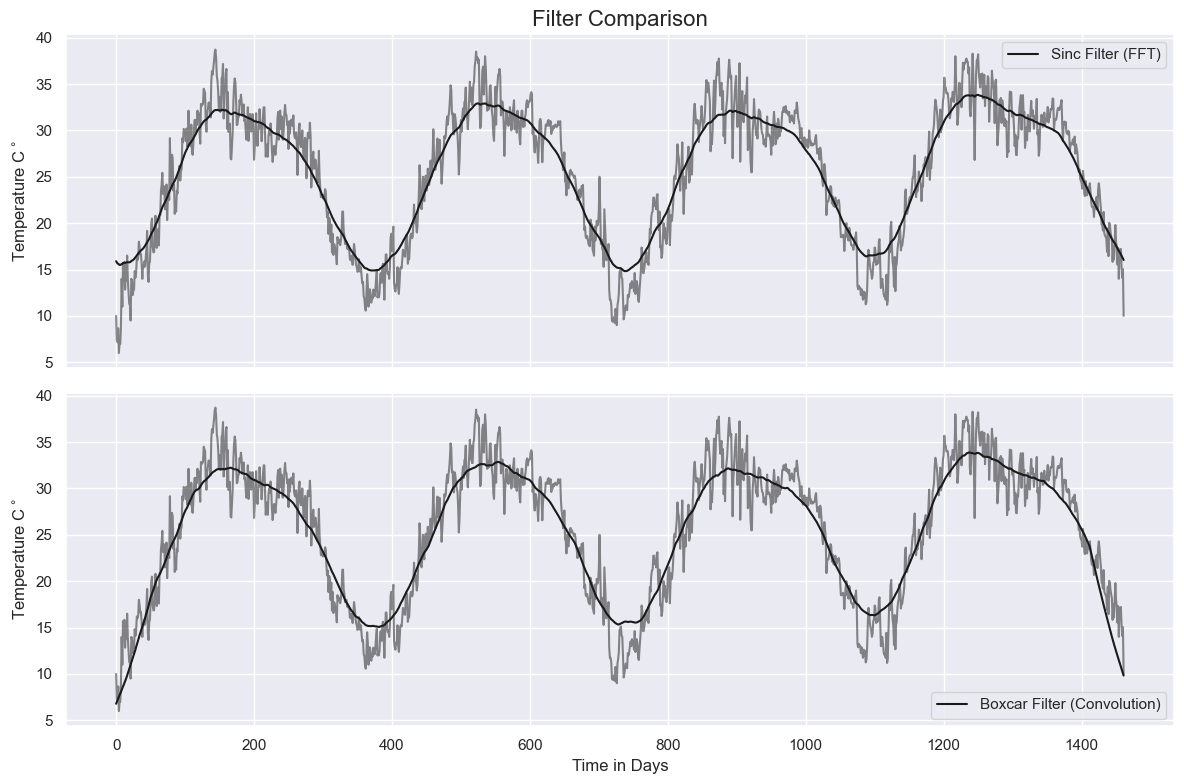

In [36]:
# Apply filters
Y_sinc_fft = Y * np.abs(Sinc)

# Perform IFT to recover cleaned signal
Y_sinc_fft_clean = np.fft.ifft(np.fft.ifftshift(Y_sinc_fft))

# Plot signals
fig, ax = plt.subplots(figsize=(12,8),nrows=2,sharex=True)
ax[0].set_title("Filter Comparison",fontsize=16)
ax[0].plot(t,Y_sinc_fft_clean,c='k',label='Sinc Filter (FFT)')
ax[0].plot(t,y,c='k',alpha=0.5)
ax[0].legend()
ax[1].plot(t,g,c='k',label='Boxcar Filter (Convolution)')
ax[1].plot(t,y,c='k',alpha=0.5)
ax[1].set_xlabel("Time in Days")
ax[1].legend()
ax[0].set_ylabel(r"Temperature C$^\circ$")
ax[1].set_ylabel(r"Temperature C$^\circ$")
plt.tight_layout()
plt.show()